# Train FCN for semantic segmentation

You must only define model structure and choose loss function

After model will work, optionally add some augmentation to improve results

## Load the data

Dataset is a part of [midv500](https://arxiv.org/abs/1807.05786) dataset.
For a simplicity all quadrangles converted to png masks.



In [9]:
# ! wget http://fmb.images.gan4x4.ru/hse/midv500p.zip
# ! unzip -q midv500p.zip

In [10]:
# это почему-то не работает...
import torch
import random

torch.manual_seed(42)
random.seed(42)

Dataset.
You can use it without modification

In [11]:
from torch.utils.data import Dataset
from torchvision import tv_tensors
from PIL import Image, ImageFile
from torchvision.io import read_image
import glob

# To bypass error on corrupted files: https://stackoverflow.com/questions/12984426/pil-ioerror-image-file-truncated-with-big-images
# ImageFile.LOAD_TRUNCATED_IMAGES = False


class MaskDataset(Dataset):
    def __init__(
        self,
        train_part=True,
        transform=None,  # for image only
        transforms=None,  # for image and mask
        target_transform=None,  # for mask only
        path="midv500p",
    ):
        self.transform = transform
        self.transforms = transforms
        self.target_transform = target_transform
        path += "/train" if train_part else "/val"
        files = glob.glob(path + "/image/*")
        self.loaded_images = []
        self.loaded_masks = []

        for filename in files:  # cache all data in memory
            self.loaded_images.append(read_image(filename) / 255)
            mask_fn = filename.replace("image", "mask").replace("jpg", "png")
            self.loaded_masks.append(read_image(mask_fn) / 255)

    def __getitem__(self, i):
        img = self.loaded_images[i]
        mask = self.loaded_masks[i]
        if self.transform is not None:
            img = self.transform(img)
        if self.transforms is not None:
            img, mask = self.transforms(tv_tensors.Image(img), tv_tensors.Mask(mask))
        if self.target_transform is not None:
            mask = self.target_transform(mask)
        return img, mask

    def __len__(self):
        return len(self.loaded_images)

Dataloaders initialization

In [12]:
import torch
from torchvision.transforms import v2
from torch.utils.data import DataLoader


v2_transforms = v2.Compose(
    [
        v2.Resize((224, 224), antialias=True),  # antialias to suppress warning
        v2.ToDtype(torch.float32, scale=True),
    ]
)


trainset = MaskDataset(train_part=True, transforms=v2_transforms)
valset = MaskDataset(train_part=False, transforms=v2_transforms)

train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=4, shuffle=False, num_workers=2)


Lets show some data

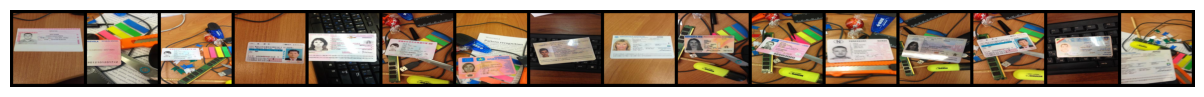

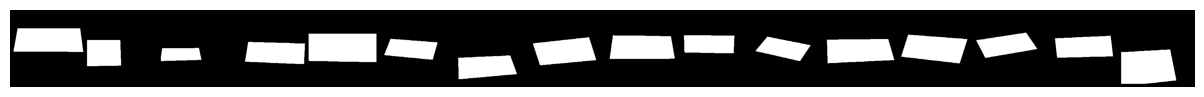

In [13]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

def show(batch, cols=16):
    cols = min(cols, len(batch))
    img_grid = make_grid(batch[:cols], padding=10, nrow=cols)
    plt.figure(figsize=(cols, 1))
    plt.axis("off")
    plt.imshow(np.transpose((img_grid * 255).numpy().astype(np.uint8), (1, 2, 0)))


images, masks = next(iter(train_loader))

show(images)
show(masks)

# Code for train

You must select Loss function

## Define your model structure here

Use [UNet](https://arxiv.org/pdf/1505.04597.pdf) - like structure.
But  decrease number of layers for simplicity.
Original images has 224x224 resolution.

In [14]:
from torch.nn import *

class MiniUnet(Module):

    def __init__(self, num_classes = 1, log_forward=False):
        super(MiniUnet, self).__init__()
        # Define basic blocks here
        # 2 downsample and 2 upsample block will be enough
        self.block1 = self.basic_block(3, 32)
        self.down1 = MaxPool2d(2)
        self.block2 = self.basic_block(32, 64)
        self.down2 = MaxPool2d(2)
        self.bottleneck = self.basic_block(64, 64)
        self.up1 = Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.block3 = self.basic_block(128, 32, mid_d=64)
        self.up2 = Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.block4 = self.basic_block(64, num_classes, mid_d=32)
        self.output = Conv2d(1, 1, 1)
        self.log_forward = log_forward

    def basic_block(self, in_d, out_d, mid_d=None):
        if not mid_d:
            mid_d = out_d
        return Sequential(
            Conv2d(in_d, mid_d, 3, padding=1),
            BatchNorm2d(mid_d),
            ReLU(),
            Conv2d(mid_d, out_d, 3, padding=1),
            BatchNorm2d(out_d),
            ReLU()
        )

    def forward(self, x):
        # Perform upsample here
        # Concatenate features from downsample path with appropriate feature maps

        out1 = self.block1(x) # (32, 224, 224)
        out = self.down1(out1) # (32, 112, 112)
        if self.log_forward: print(f'block1: {out[0].min()} {out[0].max()}')

        out2 = self.block2(out) # (64, 112, 112)
        out = self.down2(out2) # (64, 56, 56)
        if self.log_forward: print(f'block2: {out[0].min()} {out[0].max()}')

        out = self.bottleneck(out) # (64, 56, 56)
        if self.log_forward: print(f'bottleneck: {out[0].min()} {out[0].max()}')

        out = self.up1(out) # (64, 112, 112)
        out_out2 = torch.cat((out, out2), dim=1) # (128, 112, 112)
        out = self.block3(out_out2) # (32, 112, 112)
        if self.log_forward: print(f'block3: {out[0].min()} {out[0].max()}')

        out = self.up2(out) # (32, 224, 224)
        out_out1 = torch.cat((out, out1), dim=1) # (64, 224, 224)
        out = self.block4(out_out1) # (1, 224, 224)
        if self.log_forward: print(f'block4: {out[0].min()} {out[0].max()}')

        out = self.output(out) # (1, 224, 224)
        if self.log_forward: print(f'output: {out[0].min()} {out[0].max()}')

        return out # Segmentation mask

## Train the model

Select appopriate loss and metric


In [21]:
import torch.nn.functional as F
from sklearn.metrics import jaccard_score

mini_unet = MiniUnet(log_forward=False)

# Put your code here

def metric(a, b, eps=1e-6):
    i = (a * b).sum(dim=(1,2,3))
    u = (a + b).sum(dim=(1,2,3)) - i
    res = (i + eps) / (u + eps)
    j = jaccard_score(a.cpu()[0].flatten(), b.cpu()[0].flatten())
    print(j) # проверяю, что считается верно
    print(res)
    return res.mean()



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mini_unet.to(device)

optimizer = torch.optim.Adam(mini_unet.parameters(), lr = 1e-3)
criterion = BCEWithLogitsLoss()


for epoch in range(10):
    mini_unet.train()
    for img, mask in train_loader:
        img = img.to(device)
        mask = mask.to(device)

        mask_pred = mini_unet(img)

        # print(mask_pred.size())
        # print(mask_pred[0][0][0][0])

        loss = criterion(mask_pred, mask)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

    mini_unet.eval()

    img, mask = next(iter(val_loader))
    img = img.to(device)
    mask = mask.to(device)
    mask_pred = mini_unet(img)
    # print(img[0])
    # print(mask_pred[0])
    # print(F.sigmoid(mask_pred[0]))
    # print(f'min={mask_pred.min()}')
    # print(f'max={mask_pred.max()}')
    mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
    iou = metric(mask, mask_pred)
    print(f'Epoch: {epoch:.4f}, loss={loss.item():.4f}, IoU={iou:.4f}')


0.0
tensor([8.7673e-11, 5.7091e-11, 5.0508e-11, 7.8592e-11], device='cuda:0')
Epoch: 0.0000, loss=0.5412, IoU=0.0000
0.0010520778537611783
tensor([0.0011, 0.0220, 0.3299, 0.6864], device='cuda:0')
Epoch: 1.0000, loss=0.5470, IoU=0.2598
0.599158337716991
tensor([0.5992, 0.3745, 0.5014, 0.7952], device='cuda:0')
Epoch: 2.0000, loss=0.5248, IoU=0.5675
0.6488690163072067
tensor([0.6489, 0.4911, 0.6570, 0.6157], device='cuda:0')
Epoch: 3.0000, loss=0.4900, IoU=0.6032
0.4012800280554094
tensor([0.4013, 0.0886, 0.2483, 0.5334], device='cuda:0')
Epoch: 4.0000, loss=0.4987, IoU=0.3179
0.7325092056812205
tensor([0.7325, 0.6666, 0.5569, 0.9029], device='cuda:0')
Epoch: 5.0000, loss=0.4813, IoU=0.7147
0.757145362090128
tensor([0.7571, 0.6860, 0.6606, 0.9047], device='cuda:0')
Epoch: 6.0000, loss=0.4813, IoU=0.7521
0.40014027704716815
tensor([0.4001, 0.0965, 0.1143, 0.2535], device='cuda:0')
Epoch: 7.0000, loss=0.4522, IoU=0.2161
0.6822724881641241
tensor([0.6823, 0.1946, 0.6612, 0.7704], device='c

In [26]:
# дообучение
for epoch in range(10, 25):
    mini_unet.train()
    for img, mask in train_loader:
        img = img.to(device)
        mask = mask.to(device)

        mask_pred = mini_unet(img)

        # print(mask_pred.size())
        # print(mask_pred[0][0][0][0])

        loss = criterion(mask_pred, mask)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

    mini_unet.eval()

    img, mask = next(iter(val_loader))
    img = img.to(device)
    mask = mask.to(device)
    mask_pred = mini_unet(img)
    mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
    iou = metric(mask, mask_pred)
    print(f'Epoch: {epoch:.4f}, loss={loss.item():.4f}, IoU={iou:.4f}')

0.9218092566619915
tensor([0.9218, 0.6788, 0.5765, 0.9767], device='cuda:0')
Epoch: 10.0000, loss=0.4248, IoU=0.7885
0.9214448535858321
tensor([0.9214, 0.7483, 0.5902, 0.9774], device='cuda:0')
Epoch: 11.0000, loss=0.4168, IoU=0.8093
0.7681045064001403
tensor([0.7681, 0.7844, 0.9238, 0.9119], device='cuda:0')
Epoch: 12.0000, loss=0.4231, IoU=0.8471
0.9360918734110634
tensor([0.9361, 0.7426, 0.6375, 0.9434], device='cuda:0')
Epoch: 13.0000, loss=0.4300, IoU=0.8149
0.7469752761704366
tensor([0.7470, 0.4758, 0.5134, 0.9501], device='cuda:0')
Epoch: 14.0000, loss=0.3829, IoU=0.6716
0.7414745331813799
tensor([0.7415, 0.4755, 0.6306, 0.9714], device='cuda:0')
Epoch: 15.0000, loss=0.3807, IoU=0.7047
0.9155053028310982
tensor([0.9155, 0.7243, 0.6189, 0.8718], device='cuda:0')
Epoch: 16.0000, loss=0.3852, IoU=0.7826
0.9609286027157249
tensor([0.9609, 0.6483, 0.6075, 0.8137], device='cuda:0')
Epoch: 17.0000, loss=0.3713, IoU=0.7576
0.9650429297354126
tensor([0.9650, 0.5888, 0.5579, 0.9829], devi

# Display results

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def show_valset_pred(model, cols=16):
    model.to(device)
    images, pred_masks = [], []
    try:
        tmp = valset.transform
        valset.transform = None
        for batch in valset:
            with torch.no_grad():
                img, mask = batch
                images.append(img.unsqueeze(0))
                output = model(img.unsqueeze(0).to(device))
                output = (F.sigmoid(output) > 0.5).float()
                pred_masks.append(output.cpu())

    finally:
        valset.transform = tmp
    show(torch.stack(images).squeeze()[:cols, ...])
    binary_mask = torch.stack(pred_masks) > 0.5
    show(binary_mask.squeeze(1).float()[:cols, ...])

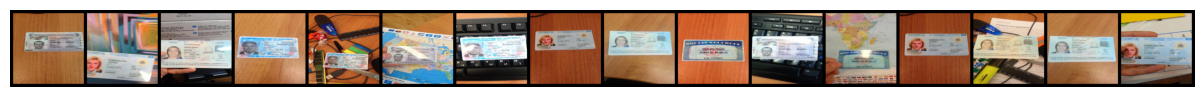

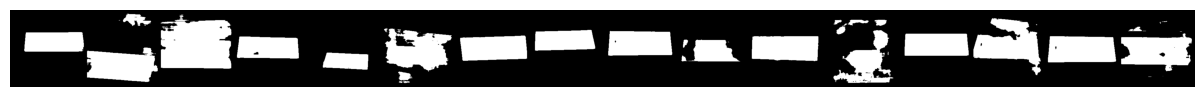

In [28]:
show_valset_pred(mini_unet, 16)

Вывод. По нераспознанной к концу понедельника причине, код работает в 1 из 10 случаев, в остальных случаях модель выдает тензор из одинаковых чисел и лосс не меняется

#Ideas for extra work

* Build segmentation model using pretrained backbone model from [SMP](https://github.com/qubvel/segmentation_models.pytorch) and compare results with obtained from your model
* Combine two different loss e.g. BCE and [IoULoss](https://smp.readthedocs.io/en/latest/losses.html#jaccardloss)
* Add augmentation from [Albumentation](https://albumentations.ai/)